In [2]:
import os
import sys
import time
import shutil
import random
from pathlib import Path
from tqdm import tqdm
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from datetime import datetime
import time
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from PIL import Image

In [3]:
def split_dataset(source_dir, output_dir, train_ratio=0.8, seed=42):
    random.seed(seed)

    categories = [cat for cat in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, cat))]
    summary = {}

    print(f"\n📁 Splitting dataset from: {source_dir}")
    print(f"💾 Output directory: {output_dir}\n")

    for category in categories:
        category_path = os.path.join(source_dir, category)
        images = os.listdir(category_path)
        random.shuffle(images)

        # images = images[:100]  # Take only the first 100 images

        split_idx = int(len(images) * train_ratio)

        train_images = images[:split_idx]
        test_images = images[split_idx:]
        summary[category] = {
            'train': len(train_images),
            'test': len(test_images)
        }

        print(f"\n🔹 Splitting category: {category}")
        for split_name, split_images in [('train', train_images), ('test', test_images)]:
            split_path = Path(output_dir) / split_name / category
            split_path.mkdir(parents=True, exist_ok=True)

            for img in tqdm(split_images, desc=f"   ➤ {split_name.upper()} [{category}]", ncols=80):
                src = Path(category_path) / img
                dst = split_path / img
                try:
                    shutil.copyfile(src, dst)
                except Exception as e:
                    print(f"⚠️ Could not copy {img}: {e}")

    # Final Summary
    print("\n📊 Split Summary:")
    total_train, total_test = 0, 0
    for category, stats in summary.items():
        print(f"   {category}: {stats['train']} train / {stats['test']} test")
        total_train += stats['train']
        total_test += stats['test']

    print("\n✅ All categories processed successfully!")
    print(f"🗂️  Total training images: {total_train}")
    print(f"🧪 Total testing images:  {total_test}")
    print(f"\n📍 Check your data at: {output_dir}/train/ and {output_dir}/test/\n")

In [4]:
split_dataset('archive/Aerial_Landscapes', 'data')


📁 Splitting dataset from: archive/Aerial_Landscapes
💾 Output directory: data


🔹 Splitting category: Agriculture


   ➤ TEST [Agriculture]: 100%|████████████████| 160/160 [00:02<00:00, 66.24it/s]



🔹 Splitting category: Airport


   ➤ TEST [Airport]: 100%|████████████████████| 160/160 [00:02<00:00, 75.02it/s]



🔹 Splitting category: Beach


   ➤ TEST [Beach]: 100%|██████████████████████| 160/160 [00:01<00:00, 80.53it/s]



🔹 Splitting category: City


   ➤ TEST [City]: 100%|███████████████████████| 160/160 [00:02<00:00, 74.72it/s]



🔹 Splitting category: Desert


   ➤ TEST [Desert]: 100%|█████████████████████| 160/160 [00:01<00:00, 87.73it/s]



🔹 Splitting category: Forest


   ➤ TEST [Forest]: 100%|█████████████████████| 160/160 [00:02<00:00, 72.22it/s]



🔹 Splitting category: Grassland


   ➤ TEST [Grassland]: 100%|██████████████████| 160/160 [00:02<00:00, 74.56it/s]



🔹 Splitting category: Highway


   ➤ TEST [Highway]: 100%|████████████████████| 160/160 [00:02<00:00, 79.41it/s]



🔹 Splitting category: Lake


   ➤ TEST [Lake]: 100%|███████████████████████| 160/160 [00:02<00:00, 76.04it/s]



🔹 Splitting category: Mountain


   ➤ TEST [Mountain]: 100%|███████████████████| 160/160 [00:01<00:00, 90.25it/s]



🔹 Splitting category: Parking


   ➤ TEST [Parking]: 100%|████████████████████| 160/160 [00:02<00:00, 78.30it/s]



🔹 Splitting category: Port


   ➤ TEST [Port]: 100%|███████████████████████| 160/160 [00:01<00:00, 85.55it/s]



🔹 Splitting category: Railway


   ➤ TEST [Railway]: 100%|████████████████████| 160/160 [00:01<00:00, 96.95it/s]



🔹 Splitting category: Residential


   ➤ TEST [Residential]: 100%|████████████████| 160/160 [00:02<00:00, 75.69it/s]



🔹 Splitting category: River


   ➤ TEST [River]: 100%|██████████████████████| 160/160 [00:02<00:00, 77.03it/s]


📊 Split Summary:
   Agriculture: 640 train / 160 test
   Airport: 640 train / 160 test
   Beach: 640 train / 160 test
   City: 640 train / 160 test
   Desert: 640 train / 160 test
   Forest: 640 train / 160 test
   Grassland: 640 train / 160 test
   Highway: 640 train / 160 test
   Lake: 640 train / 160 test
   Mountain: 640 train / 160 test
   Parking: 640 train / 160 test
   Port: 640 train / 160 test
   Railway: 640 train / 160 test
   Residential: 640 train / 160 test
   River: 640 train / 160 test

✅ All categories processed successfully!
🗂️  Total training images: 9600
🧪 Total testing images:  2400

📍 Check your data at: data/train/ and data/test/



In [5]:
def evaluate_classification(y_true, y_pred, class_names=None, verbose=True):
    """
    Evaluate classification performance and optionally print a report.
    """
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
    }

    if verbose:
        print("\n📊 Classification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names))

    return metrics

In [6]:
def plot_confusion_matrix(y_true, y_pred, class_names, normalize=False, figsize=(10, 8), title="Confusion Matrix", save_path=None):
    """
    Plot and optionally save a confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"📁 Saved confusion matrix to {save_path}")
    else:
        plt.show()


In [7]:
CACHE_DIR = "cache"
os.makedirs(CACHE_DIR, exist_ok=True)

In [8]:
def extract_sift_features(image_path, max_descriptors=500):
    try:
        img = cv2.imread(image_path, 0)
        sift = cv2.SIFT_create(nfeatures=max_descriptors)
        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is None:
            return np.zeros((max_descriptors, 128)).flatten()

        if descriptors.shape[0] > max_descriptors:
            descriptors = descriptors[:max_descriptors]
        else:
            pad = np.zeros((max_descriptors - descriptors.shape[0], 128))
            descriptors = np.vstack((descriptors, pad))

        return descriptors.flatten()
    except:
        return None

In [9]:
def prepare_data(data_dir, max_descriptors=500, use_pca=True, pca_dim=300):
    cache_name = f"{'pca' if use_pca else 'nopca'}_{os.path.basename(data_dir)}_sift_{max_descriptors}.npz"
    cache_path = os.path.join(CACHE_DIR, cache_name)

    if os.path.exists(cache_path):
        print(f"\nLoading cached features from {cache_path}")
        cache = np.load(cache_path, allow_pickle=True)
        return cache["X"], cache["y"], cache["labels"].tolist(), cache["pca"] if "pca" in cache.files else None

    print(f"\nExtracting features from: {data_dir}")
    X, y = [], []
    label_encoder = LabelEncoder()

    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        if not os.path.isdir(label_path): continue

        files = os.listdir(label_path)
        print(f"{label} - {len(files)} images")

        for file in tqdm(files, desc=f"   Extracting [{label}]", ncols=80):
            image_path = os.path.join(label_path, file)
            feat = extract_sift_features(image_path, max_descriptors)
            if feat is not None:
                X.append(feat)
                y.append(label)

    X = np.array(X)
    y = label_encoder.fit_transform(y)
    labels = label_encoder.classes_.tolist()

    pca_obj = None
    if use_pca:
        print("Applying PCA to reduce dimensionality...")
        pca_obj = PCA(n_components=pca_dim)
        # pca_obj = PCA()
        X = pca_obj.fit_transform(X)

    print(f"Caching features to {cache_path}")
    np.savez_compressed(cache_path, X=X, y=y, labels=labels, pca=pca_obj)

    return X, y, labels, pca_obj

In [10]:
def train_svm(X_train, y_train):
    print("\nTraining SVM classifier (SIFT + SVM)... This may take a few minutes.")
    start_time = time.time()
    
    clf = SVC(kernel='linear', probability=True, verbose=1)
    clf.fit(X_train, y_train)

    duration = time.time() - start_time
    print(f"Training complete. Time taken: {duration:.2f} seconds.")

    # Save model
    os.makedirs("models", exist_ok=True)
    model_path = "models/svm_classifier.joblib"
    joblib.dump(clf, model_path)
    print(f"Model saved to: {model_path}")

    return clf

In [11]:
def train_sgd(X_train, y_train):
    print("\nTraining SGDClassifier (Linear SVM approximation)...")
    clf = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, verbose=1)
    clf.fit(X_train, y_train)
    print("Training complete.")

    # Save the model
    os.makedirs("models", exist_ok=True)
    model_path = "models/sgd_classifier.joblib"
    joblib.dump(clf, model_path)
    print(f"Model saved to: {model_path}")

    return clf

In [12]:
def evaluate(clf, X_test, y_test, labels, method):
    print("\nEvaluating model...")

    preds = clf.predict(X_test)
    report = classification_report(y_test, preds, target_names=labels, digits=4)
    metrics = evaluate_classification(y_test, preds, labels, verbose=False)

    timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
    result_dir = os.path.join("results", "ML_results", f"{method}_{timestamp}")
    os.makedirs(result_dir, exist_ok=True)

    report_file = os.path.join(result_dir, "report.txt")
    with open(report_file, "w", encoding="utf-8") as f:
        f.write(f"Evaluation Timestamp: {timestamp}\n")
        f.write(f"Model: SIFT + {method}\n")
        f.write("\nSummary Metrics:\n")
        for k, v in metrics.items():
            f.write(f"  {k}: {v:.4f}\n")
        f.write("\nFull Classification Report:\n")
        f.write(report)

    print(f"Report saved to: {report_file}")

    cm_path = os.path.join(result_dir, "confmat.png")
    plot_confusion_matrix(
        y_true=y_test,
        y_pred=preds,
        class_names=labels,
        normalize=True,
        title="SIFT + SVM Confusion Matrix",
        save_path=cm_path
    )
    print(f"Confusion matrix saved to: {cm_path}")

    print(report)

In [13]:
X_train, y_train, encoder, _ = prepare_data("data/train", use_pca=True)
X_test, y_test, _, _ = prepare_data("data/test", use_pca=True)


Extracting features from: data/train
Agriculture - 640 images


   Extracting [Agriculture]: 100%|████████████| 640/640 [00:27<00:00, 23.30it/s]


Airport - 640 images


   Extracting [Airport]: 100%|████████████████| 640/640 [00:31<00:00, 20.45it/s]


Beach - 640 images


   Extracting [Beach]: 100%|██████████████████| 640/640 [00:29<00:00, 21.75it/s]


City - 640 images


   Extracting [City]: 100%|███████████████████| 640/640 [00:37<00:00, 17.20it/s]


Desert - 640 images


   Extracting [Desert]: 100%|█████████████████| 640/640 [00:27<00:00, 23.26it/s]


Forest - 640 images


   Extracting [Forest]: 100%|█████████████████| 640/640 [00:48<00:00, 13.22it/s]


Grassland - 640 images


   Extracting [Grassland]: 100%|██████████████| 640/640 [00:38<00:00, 16.47it/s]


Highway - 640 images


   Extracting [Highway]: 100%|████████████████| 640/640 [01:03<00:00, 10.08it/s]


Lake - 640 images


   Extracting [Lake]: 100%|███████████████████| 640/640 [01:00<00:00, 10.54it/s]


Mountain - 640 images


   Extracting [Mountain]: 100%|███████████████| 640/640 [01:13<00:00,  8.74it/s]


Parking - 640 images


   Extracting [Parking]: 100%|████████████████| 640/640 [01:20<00:00,  7.94it/s]


Port - 640 images


   Extracting [Port]: 100%|███████████████████| 640/640 [01:29<00:00,  7.16it/s]


Railway - 640 images


   Extracting [Railway]: 100%|████████████████| 640/640 [01:42<00:00,  6.24it/s]


Residential - 640 images


   Extracting [Residential]: 100%|████████████| 640/640 [01:51<00:00,  5.76it/s]


River - 640 images


   Extracting [River]: 100%|██████████████████| 640/640 [01:38<00:00,  6.48it/s]


Applying PCA to reduce dimensionality...
Caching features to cache\pca_train_sift_500.npz

Extracting features from: data/test
Agriculture - 160 images


   Extracting [Agriculture]: 100%|████████████| 160/160 [00:07<00:00, 20.30it/s]


Airport - 160 images


   Extracting [Airport]: 100%|████████████████| 160/160 [00:09<00:00, 17.09it/s]


Beach - 160 images


   Extracting [Beach]: 100%|██████████████████| 160/160 [00:07<00:00, 20.73it/s]


City - 160 images


   Extracting [City]: 100%|███████████████████| 160/160 [00:09<00:00, 16.99it/s]


Desert - 160 images


   Extracting [Desert]: 100%|█████████████████| 160/160 [00:06<00:00, 23.16it/s]


Forest - 160 images


   Extracting [Forest]: 100%|█████████████████| 160/160 [00:09<00:00, 16.90it/s]


Grassland - 160 images


   Extracting [Grassland]: 100%|██████████████| 160/160 [00:07<00:00, 21.66it/s]


Highway - 160 images


   Extracting [Highway]: 100%|████████████████| 160/160 [00:09<00:00, 17.00it/s]


Lake - 160 images


   Extracting [Lake]: 100%|███████████████████| 160/160 [00:08<00:00, 17.85it/s]


Mountain - 160 images


   Extracting [Mountain]: 100%|███████████████| 160/160 [00:09<00:00, 16.96it/s]


Parking - 160 images


   Extracting [Parking]: 100%|████████████████| 160/160 [00:09<00:00, 16.29it/s]


Port - 160 images


   Extracting [Port]: 100%|███████████████████| 160/160 [00:09<00:00, 16.70it/s]


Railway - 160 images


   Extracting [Railway]: 100%|████████████████| 160/160 [00:10<00:00, 14.96it/s]


Residential - 160 images


   Extracting [Residential]: 100%|████████████| 160/160 [00:09<00:00, 16.43it/s]


River - 160 images


   Extracting [River]: 100%|██████████████████| 160/160 [00:09<00:00, 16.43it/s]


Applying PCA to reduce dimensionality...
Caching features to cache\pca_test_sift_500.npz


In [14]:
clf_sgd = train_sgd(X_train, y_train)


Training SGDClassifier (Linear SVM approximation)...
-- Epoch 1
Norm: 36627.14, NNZs: 300, Bias: -10190.035384, T: 9600, Avg. loss: 10285051.154853
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 19883.89, NNZs: 300, Bias: -12910.216751, T: 19200, Avg. loss: 2919243.256397
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 13824.34, NNZs: 300, Bias: -14565.656877, T: 28800, Avg. loss: 1762813.676282
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 10231.57, NNZs: 300, Bias: -15750.903184, T: 38400, Avg. loss: 1249114.908650
Total training time: 0.02 seconds.
-- Epoch 5
Norm: 8148.85, NNZs: 300, Bias: -16665.558693, T: 48000, Avg. loss: 983680.927728
Total training time: 0.03 seconds.
-- Epoch 6
Norm: 7161.42, NNZs: 300, Bias: -17441.290041, T: 57600, Avg. loss: 816162.770570
Total training time: 0.04 seconds.
-- Epoch 7
Norm: 5858.84, NNZs: 300, Bias: -18100.814997, T: 67200, Avg. loss: 699008.766493
Total training time: 0.04 seconds.
-- Epoch 8
Norm: 5126.01, NNZs: 300, Bias:


Evaluating model...
Report saved to: results\ML_results\SGD_07-04-2025_15-01-34\report.txt
📁 Saved confusion matrix to results\ML_results\SGD_07-04-2025_15-01-34\confmat.png
Confusion matrix saved to: results\ML_results\SGD_07-04-2025_15-01-34\confmat.png
              precision    recall  f1-score   support

 Agriculture     0.1890    0.1938    0.1914       160
     Airport     0.1111    0.0312    0.0488       160
       Beach     0.0198    0.0125    0.0153       160
        City     0.1818    0.0875    0.1181       160
      Desert     0.0657    0.0563    0.0606       160
      Forest     0.1489    0.1750    0.1609       160
   Grassland     0.2398    0.7375    0.3620       160
     Highway     0.0345    0.0187    0.0243       160
        Lake     0.0671    0.0688    0.0679       160
    Mountain     0.1159    0.0500    0.0699       160
     Parking     0.1169    0.1125    0.1146       160
        Port     0.1220    0.0312    0.0498       160
     Railway     0.0942    0.0813    0.0

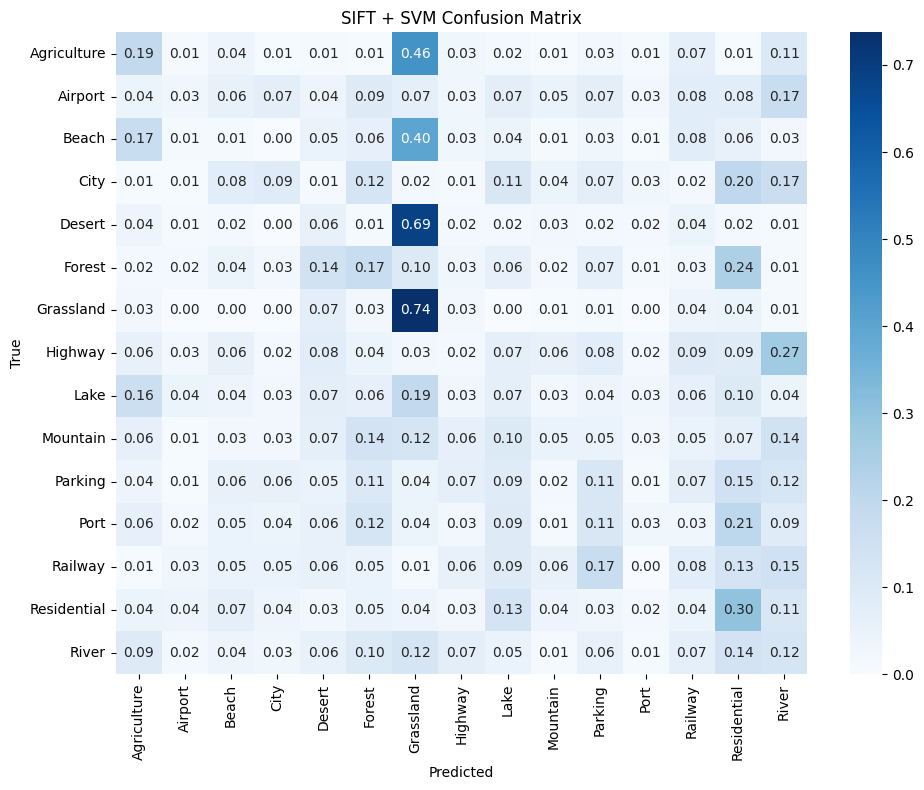

In [15]:
evaluate(clf_sgd, X_test, y_test, encoder, 'SGD')

In [ ]:
clf_svm = train_svm(X_train, y_train)


Training SVM classifier (SIFT + SVM)... This may take a few minutes.
[LibSVM]

In [ ]:
evaluate(clf_svm, X_test, y_test, encoder, 'SVM')

In [ ]:
def get_data_loaders(data_dir, batch_size=32):
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    train_ds = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
    test_ds = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_ds.classes

In [ ]:
def train_efficientnet(train_loader, num_classes, num_epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nUsing device: {device}")

    model = EfficientNet.from_pretrained('efficientnet-b0')
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")

    os.makedirs("models", exist_ok=True)
    torch.save(model.state_dict(), "models/efficientnet_b0.pth")
    print("Model saved to: models/efficientnet_b0.pth")

    return model

In [ ]:
def train_resnet(train_loader, num_classes, num_epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device_name = torch.cuda.get_device_name(0) if device.type == "cuda" else "CPU"
    print(f"\n🖥️  Training on: {device} ({device_name})")

    if device.type == "cuda":
        print(f"🧠 CUDA Memory Allocated: {torch.cuda.memory_allocated() // (1024 ** 2)} MB")

    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False  # freeze feature extractor

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=lr)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        start_time = time.time()

        progress_bar = tqdm(train_loader, desc=f"🔁 Epoch {epoch+1}/{num_epochs}", ncols=100)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

        avg_loss = running_loss / len(train_loader)
        epoch_time = time.time() - start_time
        print(f"\n✅ Epoch {epoch+1} completed — Avg Loss: {avg_loss:.4f} ⏱️ {epoch_time:.2f}s")

    # Save model
    os.makedirs("models", exist_ok=True)
    torch.save(model.state_dict(), "models/resnet18_finetuned.pth")
    print("💾 Model saved to: models/resnet18_finetuned.pth")

    return model

In [ ]:
def evaluate_model(model, test_loader, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    metrics = evaluate_classification(all_labels, all_preds, class_names, verbose=False)

    timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
    result_dir = os.path.join("results", "DL_results", f"efficientnet_eval_{timestamp}")
    os.makedirs(result_dir, exist_ok=True)

    report_file = os.path.join(result_dir, "report.txt")
    with open(report_file, "w", encoding="utf-8") as f:
        f.write(f"Evaluation Timestamp: {timestamp}\n")
        f.write("Model: EfficientNet-B0 (fine-tuned)\n")
        f.write(f"Device: {device}\n\n")
        f.write("Summary Metrics:\n")
        for k, v in metrics.items():
            f.write(f"  {k}: {v:.4f}\n")
        f.write("\nFull Classification Report:\n")
        f.write(report)

    print(f"Report saved to: {report_file}")

    cm_path = os.path.join(result_dir, "confmat.png")
    plot_confusion_matrix(
        y_true=all_labels,
        y_pred=all_preds,
        class_names=class_names,
        normalize=True,
        title="EfficientNet-B0 Confusion Matrix",
        save_path=cm_path
    )

    print(f"Confusion matrix saved to: {cm_path}")
    print("\nClassification Report (EfficientNet):")
    print(report)

In [ ]:
train_loader, test_loader, class_names = get_data_loaders('data', batch_size=32)

In [ ]:
model_efficientnet = train_efficientnet(train_loader, num_classes=len(class_names), num_epochs=5)

In [ ]:
evaluate_model(model_efficientnet, test_loader, class_names)

In [ ]:
model_resnet = train_resnet(train_loader, num_classes=len(class_names), num_epochs=5)

In [ ]:
evaluate_model(model_resnet, test_loader, class_names)

In [ ]:
def generate_gradcam(model, image_path, class_names, output_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Hook into last conv layer
    target_layer = model.layer4[1].conv2
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    # Load + preprocess image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    input_tensor = transform(img_pil).unsqueeze(0).to(device)

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()

    # Backward pass
    model.zero_grad()
    class_score = output[0, pred_class]
    class_score.backward()

    grad = gradients[0].cpu().data.numpy()[0]
    act = activations[0].cpu().data.numpy()[0]

    # Grad-CAM calculation
    weights = np.mean(grad, axis=(1, 2))
    cam = np.zeros(act.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cam -= np.min(cam)
    cam /= np.max(cam)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

    os.makedirs(output_path, exist_ok=True)
    out_path = os.path.join(output_path, f"gradcam_{os.path.basename(image_path)}")
    cv2.imwrite(out_path, overlay)

    print(f"✅ Saved Grad-CAM: {os.path.basename(image_path)} → {class_names[pred_class]}")
    return class_names[pred_class]

In [ ]:
def run_batch_gradcam(model_path="models/resnet18_finetuned.pth"):
    print("\n📸 Generating Grad-CAM for 1 image per class...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load ResNet-18
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 15)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    test_dir = "data/test"
    class_names = sorted(os.listdir(test_dir))

    # Set up output dir with timestamp
    timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
    output_dir = f"gradcam_outputs/ResNet18_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)

    log_path = os.path.join(output_dir, "report.txt")
    with open(log_path, "w", encoding="utf-8") as log_file:
        log_file.write(f"Grad-CAM Report\nModel: ResNet-18\nTimestamp: {timestamp}\n\n")

        for cls in class_names:
            class_dir = os.path.join(test_dir, cls)
            if not os.path.isdir(class_dir): continue

            images = os.listdir(class_dir)
            if len(images) == 0: continue

            image_path = os.path.join(class_dir, images[0])
            pred_class = generate_gradcam(model, image_path, class_names, output_dir)

            log_file.write(f"{os.path.basename(image_path)} → Predicted: {pred_class}\n")

    print(f"\n✅ Grad-CAM report saved to: {log_path}")